
--- KNN Model Evaluation ---
Accuracy: 0.1916
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.05      0.52      0.10        29
           2       0.00      0.00      0.00        54
           3       0.65      0.22      0.33       282
           4       0.11      0.09      0.10        45

    accuracy                           0.19       428
   macro avg       0.16      0.17      0.11       428
weighted avg       0.44      0.19      0.24       428



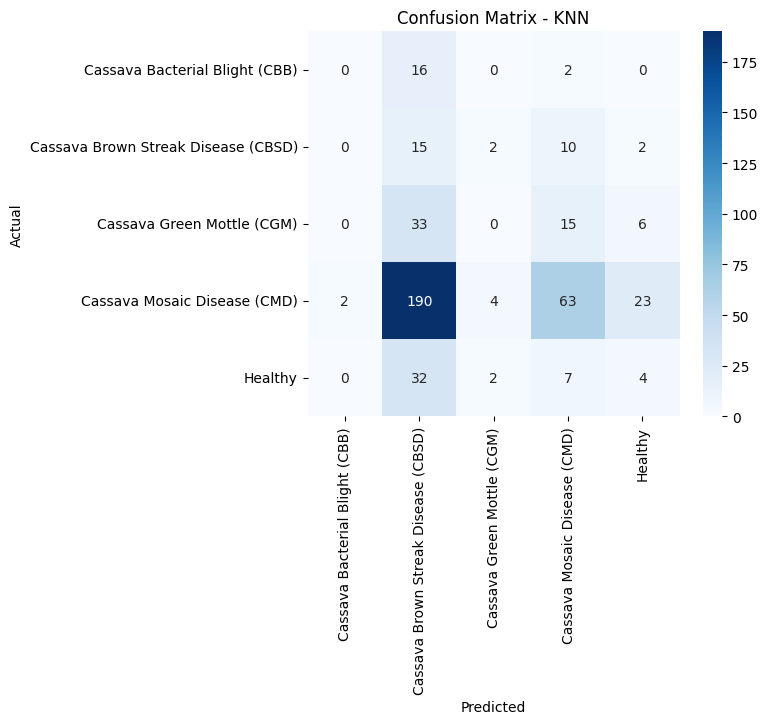


--- Random Forest Model Evaluation ---
Accuracy: 0.6589
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        18
           1       1.00      0.03      0.07        29
           2       1.00      0.00      0.00        54
           3       0.66      1.00      0.79       282
           4       0.00      0.00      0.00        45

    accuracy                           0.66       428
   macro avg       0.73      0.21      0.17       428
weighted avg       0.67      0.66      0.53       428



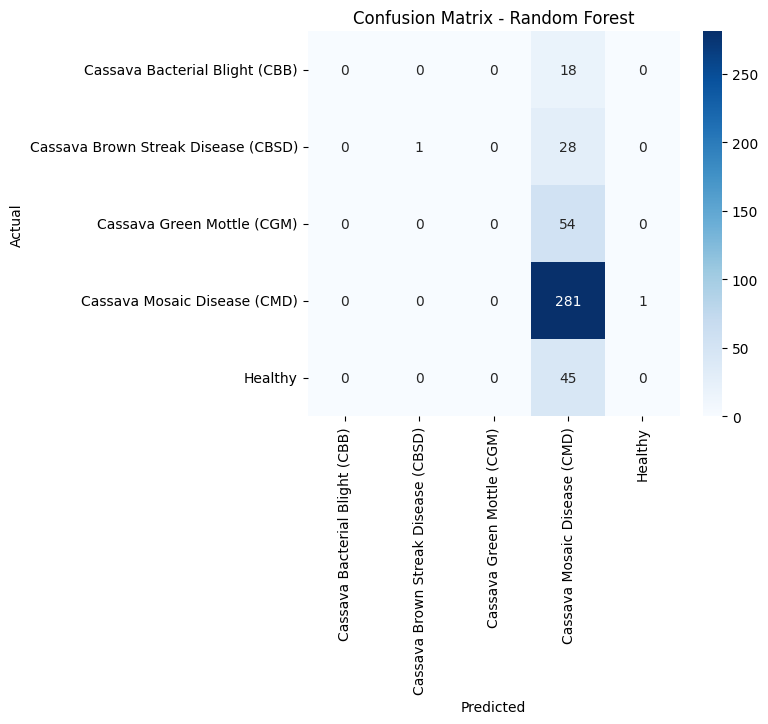

Predicted Class: Cassava Brown Streak Disease (CBSD)


In [5]:
# Import necessary libraries
import os
import cv2
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv('./train.csv')

# Load label mapping
with open('label_num_to_disease_map.json', 'r') as f:
    label_map = json.load(f)

# Select a subset of the dataset
subset_fraction = 0.1  # Use 10% of data
df_subset = df.sample(frac=subset_fraction, random_state=42)

# Define image processing parameters
Img_size = 128
image_dir = './train_images'  # Adjust this if your image folder is different

# Extract image paths and labels
image_paths = [os.path.join(image_dir, img) for img in df_subset['image_id'].values]
labels = df_subset['label'].values

# Function to load and preprocess images
def load_images(image_paths, img_size=128):
    images = []
    valid_labels = []
    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
        if img is None:
            print(f"Image not found: {img_path}")
            continue  # Skip missing images
        img = cv2.resize(img, (img_size, img_size))  # Resize
        img = img.flatten()  # Flatten into a 1D array
        images.append(img)
        valid_labels.append(label)
    return np.array(images), np.array(valid_labels)

# Load images
X, y = load_images(image_paths, Img_size)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"\n--- {model_name} Model Evaluation ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.values(), yticklabels=label_map.values())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate models
evaluate_model(knn, X_test, y_test, "KNN")
evaluate_model(rf, X_test, y_test, "Random Forest")

# Function to predict a new Cassava image
def predict_image(img_path, model):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image
    if img is None:
        print(f"Error: Image not found at {img_path}")
        return None
    img = cv2.resize(img, (Img_size, Img_size))  # Resize
    img = img.flatten().reshape(1, -1)  # Flatten and reshape for prediction
    img = scaler.transform(img)  # Scale
    prediction = model.predict(img)[0]  # Predict class label
    predicted_label = label_map[str(prediction)]  # Convert to disease name
    print(f"Predicted Class: {predicted_label}")
    return predicted_label

# Example usage (change the path to an actual image)
test_image_path = "./test_images/2216849948.jpg"
predicted_class = predict_image(test_image_path, knn)  # Use Random Forest or KNN
